In [1]:
# imports
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as VF
from torchvision import models, transforms
from torch.utils.data import TensorDataset, DataLoader

from fastai.vision.gan import basic_generator
from fastai.torch_core import requires_grad, children
from fastai.callbacks import hook_outputs

In [2]:
# download dataset from google drive

# install gdown if not installed
!pip install gdown

# create a data folder, download data into it
!mkdir brushstroke_data; cd brushstroke_data; gdown https://drive.google.com/uc?id=1Fl9K6XbDr_5lOb0J-lzjPX9SoJ9M7j1x

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
mkdir: cannot create directory ‘brushstroke_data’: File exists
Downloading...
From: https://drive.google.com/uc?id=1Fl9K6XbDr_5lOb0J-lzjPX9SoJ9M7j1x
To: /home/snowballfight/PycharmProjects/Brushstroke_GAN_Flask_Project/brushstroke_data/episodes_42.npz
206MB [00:19, 10.8MB/s] 


In [3]:
#load data into memory
data = np.load('brushstroke_data/' + 'episodes_42.npz')
stroke_data = data['strokes']

This dataset contains 100000 strokes


<function matplotlib.pyplot.show(*args, **kw)>

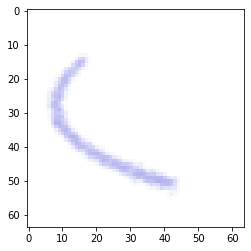

In [4]:
# visualize data
# total number of strokes in dataset
print(f'This dataset contains {stroke_data.shape[0]} strokes')

# visualizing stroke 5 in dataset
example_stroke = stroke_data[5][:,:]
plt.grid(False)
plt.imshow(example_stroke, cmap='Greys')
plt.show

In [5]:
# define important parameters for generator
condition_dim = 12
image_size = 64
fc_dim = int(image_size * image_size)
channels = 3
n_extra_layers = 1

In [6]:
# define generator class
# FC + DC layer with fastai basic_generator implementation
class Generator(nn.Module):
    
    def __init__(self, condition_dim, fc_dim, in_size, n_channels, n_extra_layers):
        super().__init__()
        # Fully connected layer
        self.fc = nn.Linear(condition_dim, fc_dim)
        self.generator = basic_generator(in_size=in_size,
                                         n_channels=n_channels,
                                         n_extra_layers=n_extra_layers,
                                         noise_sz=fc_dim)
        
    def forward(self, x):
        x = self.fc(x)
        x = self.generator(x.view(x.size(0), x.size(1), 1, 1))
        return x

In [7]:
# instantiate generator
generator = Generator(condition_dim=condition_dim,
                     fc_dim=fc_dim,
                     in_size=image_size,
                     n_channels=channels,
                     n_extra_layers=n_extra_layers)

In [8]:
# visualize generator layers
generator

Generator(
  (fc): Linear(in_features=12, out_features=4096, bias=True)
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNor

In [10]:
# define batch size
batch_size = 256

# define dataloaders and dataset used in training
actions = data['actions']
strokes = data['strokes']
print(actions.shape)
print(strokes.shape)
actions = torch.stack([torch.from_numpy(action).float() for action in actions])
strokes = torch.stack([torch.from_numpy(stroke).permute(2,0,1) for stroke in stroke_data])

# use generic pytorch datasets and dataloader classes
dataset = TensorDataset(strokes, actions)
dataloader = DataLoader(dataset, batch_size = 256, shuffle=False)

# define stroke transformer we will use during training
strokes_tfms = transforms.Compose([transforms.Lambda(lambda x: x.float()),
                                   transforms.Lambda(lambda x: x.div(255))
                                  ])

(100000, 12)
(100000, 64, 64, 3)


In [10]:
# define learning rate
learning_rate = .003

# define optimizer
# using ADAM
optimizer = optim.Adam(generator.parameters(), lr= learning_rate, betas=(0.5, 0.9))

In [14]:
# define loss
base_loss = F.mse_loss


In [15]:
# define directories to save model to
root = 'generator_models/'
model = 'brushstroke_gan_non_adversarial_generator_param.pth'

if not os.path.isdir(root):
    os.mkdir(root)

Device : cuda
Starting Generator Training
epoch 1
epoch 1/10 | 1/391 complete!
loss: 8.490684509277344
true


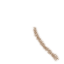

pred


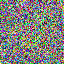

---
epoch 1/10 | 51/391 complete!
loss: 6.077373027801514
true


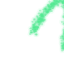

pred


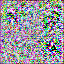

---
epoch 1/10 | 101/391 complete!
loss: 5.4630537033081055
true


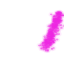

pred


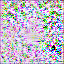

---
epoch 1/10 | 151/391 complete!
loss: 5.082633972167969
true


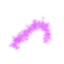

pred


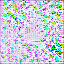

---
epoch 1/10 | 201/391 complete!
loss: 4.785922527313232
true


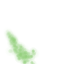

pred


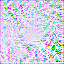

---
epoch 1/10 | 251/391 complete!
loss: 4.570568084716797
true


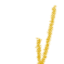

pred


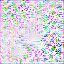

---
epoch 1/10 | 301/391 complete!
loss: 4.404451847076416
true


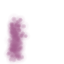

pred


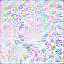

---
epoch 1/10 | 351/391 complete!
loss: 4.266856670379639
true


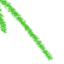

pred


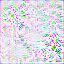

---
epoch 2
epoch 2/10 | 1/391 complete!
loss: 3.245304584503174
true


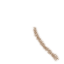

pred


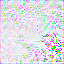

---
epoch 2/10 | 51/391 complete!
loss: 3.233628511428833
true


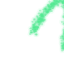

pred


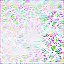

---
epoch 2/10 | 101/391 complete!
loss: 3.1934962272644043
true


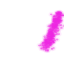

pred


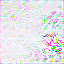

---
epoch 2/10 | 151/391 complete!
loss: 3.153521776199341
true


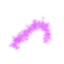

pred


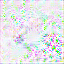

---
epoch 2/10 | 201/391 complete!
loss: 3.1037087440490723
true


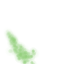

pred


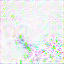

---
epoch 2/10 | 251/391 complete!
loss: 3.0544321537017822
true


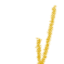

pred


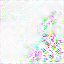

---
epoch 2/10 | 301/391 complete!
loss: 2.967087745666504
true


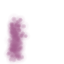

pred


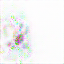

---
epoch 2/10 | 351/391 complete!
loss: 2.8590102195739746
true


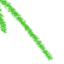

pred


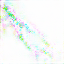

---
epoch 3
epoch 3/10 | 1/391 complete!
loss: 2.2633421421051025
true


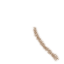

pred


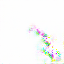

---
epoch 3/10 | 51/391 complete!
loss: 2.035402297973633
true


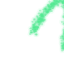

pred


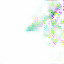

---
epoch 3/10 | 101/391 complete!
loss: 1.9939113855361938
true


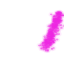

pred


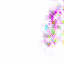

---
epoch 3/10 | 151/391 complete!
loss: 1.9560377597808838
true


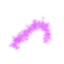

pred


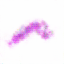

---
epoch 3/10 | 201/391 complete!
loss: 1.924802303314209
true


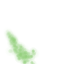

pred


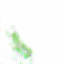

---
epoch 3/10 | 251/391 complete!
loss: 1.896191120147705
true


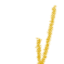

pred


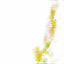

---
epoch 3/10 | 301/391 complete!
loss: 1.869182825088501
true


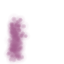

pred


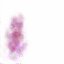

---
epoch 3/10 | 351/391 complete!
loss: 1.8422133922576904
true


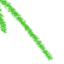

pred


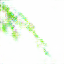

---
epoch 4
epoch 4/10 | 1/391 complete!
loss: 1.648987889289856
true


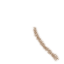

pred


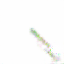

---
epoch 4/10 | 51/391 complete!
loss: 1.620643138885498
true


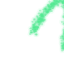

pred


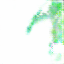

---
epoch 4/10 | 101/391 complete!
loss: 1.5998866558074951
true


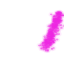

pred


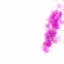

---
epoch 4/10 | 151/391 complete!
loss: 1.5831868648529053
true


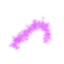

pred


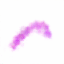

---
epoch 4/10 | 201/391 complete!
loss: 1.5703109502792358
true


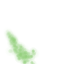

pred


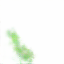

---
epoch 4/10 | 251/391 complete!
loss: 1.5581356287002563
true


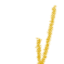

pred


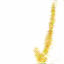

---
epoch 4/10 | 301/391 complete!
loss: 1.5445256233215332
true


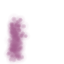

pred


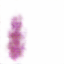

---
epoch 4/10 | 351/391 complete!
loss: 1.5303890705108643
true


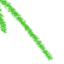

pred


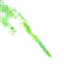

---
epoch 5
epoch 5/10 | 1/391 complete!
loss: 1.4282867908477783
true


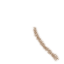

pred


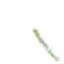

---
epoch 5/10 | 51/391 complete!
loss: 1.4199821949005127
true


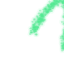

pred


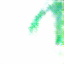

---
epoch 5/10 | 101/391 complete!
loss: 1.4073933362960815
true


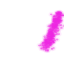

pred


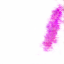

---
epoch 5/10 | 151/391 complete!
loss: 1.39881432056427
true


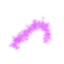

pred


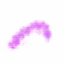

---
epoch 5/10 | 201/391 complete!
loss: 1.3927003145217896
true


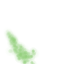

pred


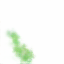

---
epoch 5/10 | 251/391 complete!
loss: 1.3876205682754517
true


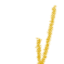

pred


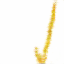

---
epoch 5/10 | 301/391 complete!
loss: 1.380764365196228
true


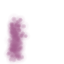

pred


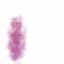

---
epoch 5/10 | 351/391 complete!
loss: 1.3722394704818726
true


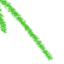

pred


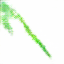

---
epoch 6
epoch 6/10 | 1/391 complete!
loss: 1.3721296787261963
true


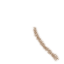

pred


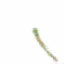

---
epoch 6/10 | 51/391 complete!
loss: 1.3158915042877197
true


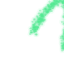

pred


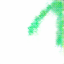

---
epoch 6/10 | 101/391 complete!
loss: 1.3045108318328857
true


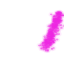

pred


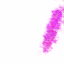

---
epoch 6/10 | 151/391 complete!
loss: 1.2997307777404785
true


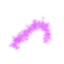

pred


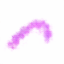

---
epoch 6/10 | 201/391 complete!
loss: 1.2963297367095947
true


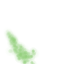

pred


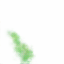

---
epoch 6/10 | 251/391 complete!
loss: 1.2938463687896729
true


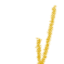

pred


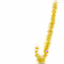

---
epoch 6/10 | 301/391 complete!
loss: 1.2896521091461182
true


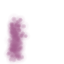

pred


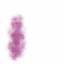

---
epoch 6/10 | 351/391 complete!
loss: 1.2839939594268799
true


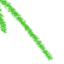

pred


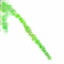

---
epoch 7
epoch 7/10 | 1/391 complete!
loss: 1.3654204607009888
true


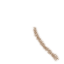

pred


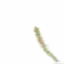

---
epoch 7/10 | 51/391 complete!
loss: 1.2537158727645874
true


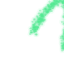

pred


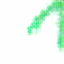

---
epoch 7/10 | 101/391 complete!
loss: 1.2423845529556274
true


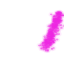

pred


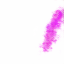

---
epoch 7/10 | 151/391 complete!
loss: 1.2391375303268433
true


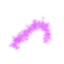

pred


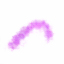

---
epoch 7/10 | 201/391 complete!
loss: 1.23660409450531
true


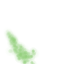

pred


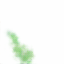

---
epoch 7/10 | 251/391 complete!
loss: 1.235907793045044
true


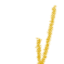

pred


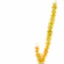

---
epoch 7/10 | 301/391 complete!
loss: 1.2325395345687866
true


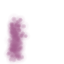

pred


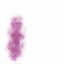

---
epoch 7/10 | 351/391 complete!
loss: 1.227791666984558
true


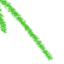

pred


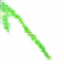

---
epoch 8
epoch 8/10 | 1/391 complete!
loss: 1.2746402025222778
true


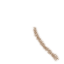

pred


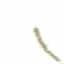

---
epoch 8/10 | 51/391 complete!
loss: 1.199580430984497
true


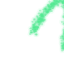

pred


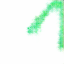

---
epoch 8/10 | 101/391 complete!
loss: 1.1939384937286377
true


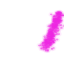

pred


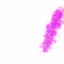

---
epoch 8/10 | 151/391 complete!
loss: 1.1914950609207153
true


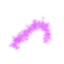

pred


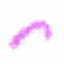

---
epoch 8/10 | 201/391 complete!
loss: 1.1907844543457031
true


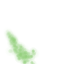

pred


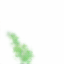

---
epoch 8/10 | 251/391 complete!
loss: 1.189868688583374
true


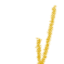

pred


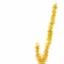

---
epoch 8/10 | 301/391 complete!
loss: 1.187511920928955
true


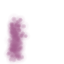

pred


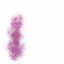

---
epoch 8/10 | 351/391 complete!
loss: 1.183510661125183
true


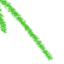

pred


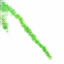

---
epoch 9
epoch 9/10 | 1/391 complete!
loss: 1.2553491592407227
true


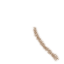

pred


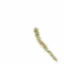

---
epoch 9/10 | 51/391 complete!
loss: 1.1679720878601074
true


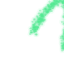

pred


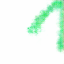

---
epoch 9/10 | 101/391 complete!
loss: 1.161932110786438
true


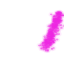

pred


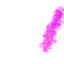

---
epoch 9/10 | 151/391 complete!
loss: 1.157477617263794
true


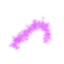

pred


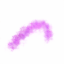

---
epoch 9/10 | 201/391 complete!
loss: 1.156611680984497
true


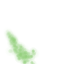

pred


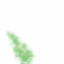

---
epoch 9/10 | 251/391 complete!
loss: 1.1562734842300415
true


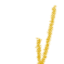

pred


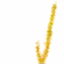

---
epoch 9/10 | 301/391 complete!
loss: 1.1547448635101318
true


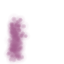

pred


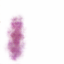

---
epoch 9/10 | 351/391 complete!
loss: 1.1515346765518188
true


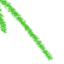

pred


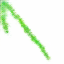

---
epoch 10
epoch 10/10 | 1/391 complete!
loss: 1.2211205959320068
true


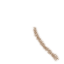

pred


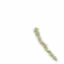

---
epoch 10/10 | 51/391 complete!
loss: 1.1324864625930786
true


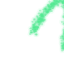

pred


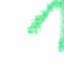

---
epoch 10/10 | 101/391 complete!
loss: 1.1291277408599854
true


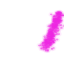

pred


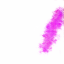

---
epoch 10/10 | 151/391 complete!
loss: 1.127274751663208
true


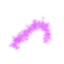

pred


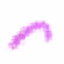

---
epoch 10/10 | 201/391 complete!
loss: 1.1267539262771606
true


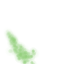

pred


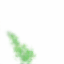

---
epoch 10/10 | 251/391 complete!
loss: 1.1268421411514282
true


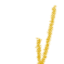

pred


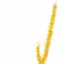

---
epoch 10/10 | 301/391 complete!
loss: 1.1256964206695557
true


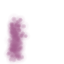

pred


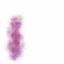

---
epoch 10/10 | 351/391 complete!
loss: 1.1231920719146729
true


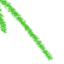

pred


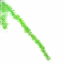

---


In [17]:
# training
train_epoch = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device : {device}')

print('Starting Generator Training')

# move generator to device
generator.to(device)

for epoch in range(train_epoch):
    
    print(f'epoch {epoch + 1}')
    
    losses = []
    
    for num_iter, (stroke, action) in enumerate(dataloader):
        # move action and stroke to device
        action = action.to(device)
        stroke = torch.stack([strokes_tfms(s) for s in stroke]).to(device)
        
        # training generator
        optimizer.zero_grad()
        
        generator_output = generator(action)
        
        generator_train_loss = base_loss(generator_output, stroke)
        
        generator_train_loss.backward()
        
        optimizer.step()
        
        losses.append(generator_train_loss.data.item())
        
        if (num_iter % 50) == 0:
            print(f'epoch {epoch+1}/{train_epoch} | {num_iter+1}/{len(dataloader)} complete!')

            print(f'loss: {torch.mean(torch.FloatTensor(losses))}')
            # ---
            s = stroke[0].clone().cpu()
            print('true')
            display(VF.to_pil_image(s))

            #--- 
            g = generator_output[0].clone().cpu()
            print('pred')
            display(VF.to_pil_image(g))
            print('---')
# optionally, save the model        
# print('saving the Generator ... ')
# torch.save(generator.state_dict(), root + model)
# print('done.')

In [ ]:
# check if the model saved properly
!ls generator_models